In [12]:
import pandas as pd
from arango import ArangoClient

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import minmax_scale
import networkx as nx

import plotly.graph_objects as go


import plotly.io as pio
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import minmax_scale
import networkx as nx
import plotly.graph_objects as go
import plotly.io as pio

import numpy as np

client = ArangoClient(hosts="http://localhost:8529")
sys_db = client.db('_system', username='root',password='root')
db = client.db("text", username="root", password="root")

## Graphe de co-occurence


In [16]:
pio.renderers.default='browser'

lemmas_from_sentences = pd.DataFrame(list(db.aql.execute('''for start_vertex in sentences
        for v, e in inbound start_vertex is_from
        filter e.type == 'lemmaToSent'
        collect sent = e._to, lemmas = v.lemma into groups ={
        "sentence" : e._to,
        "lemma" : v.lemma
        }
        return {"sentence":sent,
                "lemma":lemmas}
                '''))).groupby('sentence')['lemma'].apply(' '.join)

vectorizer = CountVectorizer(min_df=10)

termDocMatrix  = vectorizer.fit_transform(lemmas_from_sentences)

coOccurenceMatrix = termDocMatrix.T.dot(termDocMatrix)
# retire les liens d'un nodeà lui même dnas la matrice

coOccurenceMatrix.setdiag(0)

# construction du graphe
G = nx.from_scipy_sparse_array(coOccurenceMatrix,
                                parallel_edges=False)

# retire les arretes qui connectent un noeud à lui même 

G.remove_edges_from(nx.selfloop_edges(G))



# définition de la position des noeuds par spatialisation fruchterman reingold

FRL = nx.drawing.layout.fruchterman_reingold_layout(G)

# kamada kawai
# KMK = nx.drawing.layout.kamada_kawai_layout(G)

for i in range(0,len(FRL)):
    G.nodes[i]['pos'] = FRL[i]
    


def make_edge(x, y, width,scaledWidth):
    """
    Args:
        x: a tuple of the x from and to, in the form: tuple([x0, x1, None])
        y: a tuple of the y from and to, in the form: tuple([y0, y1, None])
        width: The width of the line

    Returns:
        a Scatter plot which represents a line between the two points given. 
    """
    return  go.Scatter(
                x=x,
                y=y,
                line=dict(width=width,color='#888'),
                hoverinfo='none',
                mode='lines',
                opacity=scaledWidth)




xTupleList = []
yTupleList = []

for ed in G.edges(): 
    xfrom = G.nodes()[ed[0]]['pos'][0]
    yfrom = G.nodes()[ed[0]]['pos'][1]
    
    xto = G.nodes()[ed[1]]['pos'][0]
    yto = G.nodes()[ed[1]]['pos'][1]
    xTupleList.append((xfrom,xto,None))
    yTupleList.append((yfrom,yto,None))

widthList = np.array([G.edges[ed]['weight'] for ed in G.edges()])

scaledWidthList = minmax_scale(widthList)



edge_trace = [make_edge(x,y,w,sw) for x,y,w,sw in zip(xTupleList,yTupleList,widthList*0.5,scaledWidthList)]




node_x = []
node_y = []
for node in G.nodes():
    x, y = G.nodes[node]['pos']
    node_x.append(x)
    node_y.append(y)
    
    
    

node_trace = go.Scatter(
    x=node_x, y=node_y,
    mode='markers+text',
    text='text',
    textposition='top center',
    marker=dict(
        showscale=True,
        # colorscale options
        #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
        #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
        #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
        colorscale='YlGnBu',
        reversescale=True,
        color=[],
        size=10,
        colorbar=dict(
            thickness=15,
            title="Nombre d'occurences",
            xanchor='left',
            titleside='right'
        ),
        line_width=2))




node_trace.marker.color = list(vectorizer.vocabulary_.values())
node_trace.text = list(vectorizer.vocabulary_.keys())


layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', # transparent background
    plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)


fig = go.Figure(layout = layout)

# Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)# Add node trace
fig.add_trace(node_trace)# Remove legend
fig.update_layout(showlegend = False)

## visualisation de relations syntagmatiques

In [227]:
def get_syntagmatic_data(word):
    data = pd.DataFrame(list(db.aql.execute(f'''
    for token in tokens
    filter token.token == '{word}'
    let selected_token = token._id

    for v, e in 1..1 
    any selected_token
    syntagmatic_link
    filter e.dep_relation != 'ROOT'

    return {{"token": v.token,
            "relation" : e.dep_relation,
            "from_sentence" : e.from_sentence_number,
            "head_pos_tag" : e.head_pos_tag
            }}


                    ''')))    
    # à remplacer avec une requette donnant le titre du document
    data['doc'] = data['from_sentence'].str.extract('(doc\d+)')
    return data

In [253]:
faire = get_syntagmatic_data('faire').sort_values('from_sentence')

In [254]:
faire['count'] = 1

In [255]:
faire.groupby('token').sum()

,count
token,
accepter,2
advenir,1
carriére,2
contrainte,1
description,1
dispositions,1
durer,1
découle,1
découvrir,1


In [260]:
faire_pivot = faire.pivot_table(index='token',columns='doc',values='count',aggfunc='sum')
faire_pivot

In [270]:
faire

,token,relation,from_sentence,head_pos_tag,doc,count
16,durer,dep,doc0sent0,VERB,doc0,1
0,peut-être,advmod,doc0sent7,VERB,doc0,1
1,pied,obj,doc0sent7,VERB,doc0,1
2,objet,obj,doc1sent123,VERB,doc1,1
3,description,obl:arg,doc1sent123,VERB,doc1,1
18,jouer,dep,doc1sent262,VERB,doc1,1
19,jouer,dep,doc1sent263,VERB,doc1,1
17,jouer,dep,doc1sent55,VERB,doc1,1
8,pression,obj,doc2sent249,VERB,doc2,1
7,dérive,obl:arg,doc2sent249,VERB,doc2,1


In [301]:
edgelist = faire.groupby(['token','doc']).aggregate('sum')
edgelist

,,count
token,doc,
accepter,doc4,2
advenir,doc4,1
carriére,doc4,2
contrainte,doc4,1
description,doc1,1
dispositions,doc4,1
durer,doc0,1
découle,doc4,1
découvrir,doc4,1


In [315]:
real_edgelist = pd.DataFrame(edgelist.to_records())
real_edgelist.rename(columns={"token":'from',
                              'doc':'to'}, inplace=True)
real_edgelist

,from,to,count
0,accepter,doc4,2
1,advenir,doc4,1
2,carriére,doc4,2
3,contrainte,doc4,1
4,description,doc1,1
5,dispositions,doc4,1
6,durer,doc0,1
7,découle,doc4,1
8,découvrir,doc4,1
9,dérive,doc2,1


In [324]:
edgelist_token_doc = pd.DataFrame(real_edgelist.groupby('to').aggregate('sum').to_records())
edgelist_token_doc['from'] = 'faire'

In [325]:
edgelist_token_doc

In [328]:
full_edgelist = pd.concat([real_edgelist, edgelist_token_doc])

In [329]:
G = nx.from_pandas_edgelist(full_edgelist,'from','to',edge_attr='count')

In [333]:
FRL = nx.drawing.layout.fruchterman_reingold_layout(G)

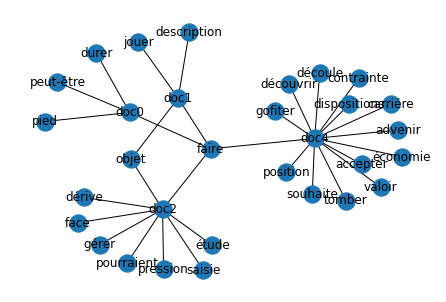

In [343]:
nx.draw_kamada_kawai(G,with_labels=True)

In [80]:
fig = go.Figure()
fig.add_trace(go.Scatter(
x = [0],
y = [0],
mode = 'markers+text',
text = 'étudiant',
textposition='top center'))

fig.update_traces(marker = dict(size=16))

fig.update_layout(
font=dict(
    size = 18))

Signature: nx.barbell_graph(m1, m2, create_using=None)
Docstring:
Returns the Barbell Graph: two complete graphs connected by a path.

For $m1 > 1$ and $m2 >= 0$.

Two identical complete graphs $K_{m1}$ form the left and right bells,
and are connected by a path $P_{m2}$.

The `2*m1+m2`  nodes are numbered
    `0, ..., m1-1` for the left barbell,
    `m1, ..., m1+m2-1` for the path,
    and `m1+m2, ..., 2*m1+m2-1` for the right barbell.

The 3 subgraphs are joined via the edges `(m1-1, m1)` and
`(m1+m2-1, m1+m2)`. If `m2=0`, this is merely two complete
graphs joined together.

This graph is an extremal example in David Aldous
and Jim Fill's e-text on Random Walks on Graphs.
File:      ~/projects/text explorer/text_explorer/lib/python3.8/site-packages/networkx/generators/classic.py
Type:      function


In [ ]:
nx.drawing.layout.fruchterman_reingold_layout?

In [85]:
import matplotlib.pyplot as plt

In [217]:
first_offset = np.linspace(4,0,10)
second_offset = np.linspace(4,0,50)

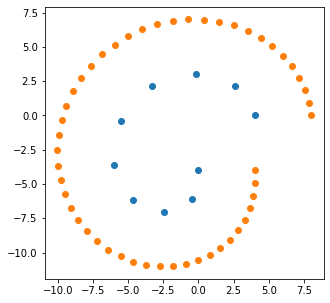

In [221]:
plt.figure(figsize=(5,5))
r = 4
plt.scatter(x=[-r * np.cos(np.linspace(np.pi,-np.pi,10))-first_offset],
            y=[-r * np.sin(np.linspace(np.pi,-np.pi,10))-first_offset])
plt.scatter(x=[-8 * np.cos(np.linspace(np.pi,-np.pi,50))-second_offset],
            y=[-8 * np.sin(np.linspace(np.pi,-np.pi,50))-second_offset])

In [201]:
a = np.array([[1,2],[1,2]])
b = np.array([[0,1],[1,0]])

In [204]:
a.dot(b)

array([[2, 1],
       [2, 1]])

In [203]:
a

array([[1, 2],
       [1, 2]])

In [94]:
np.sin([-1,-0.5,0,0.5,1])

array([-0.84147098, -0.47942554,  0.        ,  0.47942554,  0.84147098])

array([0.84147098, 0.90929743, 0.14112001])